In [1]:
%load_ext autoreload
%autoreload 2
from cmb_simulation import *
from scattering_transform import *

In [2]:
J = 8
N = 512
Q = STQueue(J, N)

In [141]:
d = 3/60/180*np.pi
cmb = CMBSpectra(getCambSpectra())
detector = Detector(*cmb_s4_params)
shuffled_inds = np.random.permutation(512)
i_cmb = 0

teb_temp = TEB(CMBMap(d, N), None, None)
re = RotationEstimator(cmb, teb_temp, detector, lensed=True)
normEB = convolveFull(re.normTerms('EB', 5, 3000), re.ls).real[:,:re.N//2+1]

def qeCircularStrings(teb, A, r, n, lmin, lmax, lensed=True):
    N = teb.N
    a = CMBMap(d, N, real=rotationFromCircularStrings(N, A, r, n))
    teb_rot = rotateTEB(teb, a)
    teb_rot_obs = detector.addNoise(teb_rot)
    qe_rot = RotationEstimator(cmb, teb_rot_obs, detector, lensed=lensed)
    qe_rot_EB = qe_rot.evaluateQE('EB', lmin, lmax, norm=normEB) # generalise this
    return qe_rot_EB

def newQEMap(A, r, n):
    global i_cmb
    lmin = 5
    lmax = 3000
    num = f'{shuffled_inds[i_cmb]:03d}'
    T_r = np.load('dat/T_len/T_len_%s.npy' % num)
    E_r = np.load('dat/E_len/E_len_%s.npy' % num)
    B_r = np.load('dat/B_len/B_len_%s.npy' % num)
    T = CMBMap(d, N, real=T_r)
    E = CMBMap(d, N, real=E_r)
    B = CMBMap(d, N, real=B_r)
    teb = TEB(T, E, B)
    qe_map = qeCircularStrings(teb, A, r, n, lmin, lmax, lensed=True).r
    i_cmb = (i_cmb + 1) % 512
    return qe_map

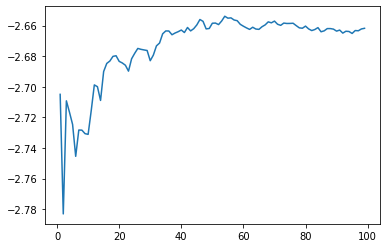

In [174]:
plt.plot(range(1, 100), [np.mean([QQ.coefs[i][5,7] for i in range(j)]) for j in range(1, 100)])

In [165]:
def log_prob(param, mean0, cov0, iter):
    '''
    cov : (J*(J-1)/2, J*(J-1)/2) array
        Covariance matrix of fiducial parameters
    iter : int
        Number of realisations to compute for estimating average
    '''
    A, r, n = param
    if A<0 or A>1.5 or r<100 or r>1000 or n<1 or n>60:
        return -np.inf
    n = int(n)
    data = np.array([
        Q.scatteringTransform(A=A, r=r, n=n).flatten(include_s1=True) for _ in range(iter)
    ])
    mean = np.mean(data, axis=0)[-3:]
    return -0.5 * (mean - mean0) @ np.linalg.inv(cov0) @ (mean-mean0)

In [101]:
with open('dat/single_realisation_stats0.pk', 'rb') as file:
    param0, mean0, cov0 = pk.load(file)

In [106]:
param0

[{'multi': 256, 'A': 0.8, 'r': 600, 'n': 25}]

In [170]:
print(log_prob((0.1, 600, 25), mean0[-3:], cov0[-3:,-3:], 5))
print(log_prob((0.5, 600, 1), mean0[-3:], cov0[-3:,-3:], 5))

-802.8281974319957
-802.8281974339011


In [171]:
print(log_prob((0.8, 600, 25), mean0[-3:], cov0[-3:,-3:], 5))
print(log_prob((1.5, 600, 1), mean0[-3:], cov0[-3:,-3:], 5))

-802.8281974517453
-802.8281974378896


In [117]:
import emcee as mc
import multiprocessing
from multiprocessing import Pool

In [118]:
multiprocessing.set_start_method('fork') # Necessary for python 3.8 on macOS

In [175]:
# MCMC
nwalkers = 16
p0 = np.array([(
    np.random.random() * (1.5-0.1) + 0.1,
    np.random.random() * (1000-100) + 100,
    np.random.choice(np.arange(1, 51))
) for _ in range(nwalkers)]) # A, r, n
pool = Pool()
sampler = mc.EnsembleSampler(nwalkers, 3, log_prob, args=[mean0[-3:], cov0[-3:,-3:], 40], pool=pool)
state = sampler.run_mcmc(p0, 1, progress='notebook')

In [146]:
state = sampler.run_mcmc(state, 70, progress='notebook')

  0%|          | 0/70 [00:00<?, ?it/s]

In [155]:
with open('dat/mcmc_state_3dof_0.pk', 'ab') as file:
    pk.dump(state, file)

In [150]:
from getdist import plots, MCSamples

Removed no burn in


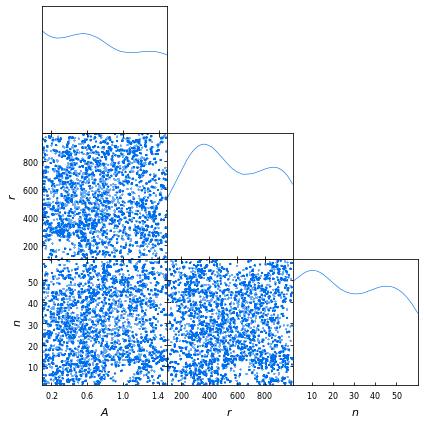

In [158]:
samples = sampler.get_chain(flat=True, discard=150)
mcsamples = MCSamples(samples=samples, names=['A', 'r', 'n'], labels=['A', 'r', 'n'], ranges={'A': [0.1, 1.5], 'r': [100, 1000], 'n': [1, 60]})
g = plots.get_subplot_plotter()
g.triangle_plot(mcsamples, filled=True)

<ErrorbarContainer object of 3 artists>

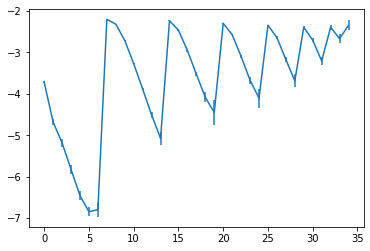

In [163]:
plt.errorbar(range(35), mean0, [np.sqrt(cov0[i,i]) for i in range(35)])

In [138]:
A_rand = np.random.random() * (2-0.1) + 0.1
r_rand = np.random.random() * (1000-100) + 100
n_rand = np.random.choice(np.arange(1, 51))
params = [
    {'multi': 512, 'A': A_rand, 'r': r_rand, 'n': n_rand}
]
print(params)
Q.init(newQEMap, params)

[{'multi': 512, 'A': 1.8105969956563313, 'r': 540.1271194576864, 'n': 4}]


In [139]:
Q.run()

Simulating realisation 4/512 (4/512 in queue) with parameters {'A': 1.8105969956563313, 'r': 540.1271194576864, 'n': 4}, previous cycle took 11.13 s
Interrupted


In [22]:
import pickle as pk

with open('dat/coef_stats1.pk', 'ab') as file:
    pk.dump(Q.coef_stats[0], file)

# Q.coef_stats[0]

PicklingError: Can't pickle <class 'kymatio.numpy.ScatteringNumPy2D'>: attribute lookup ScatteringNumPy2D on kymatio.numpy failed

In [20]:
with open('dat/coef_stats0.pk', 'rb') as file:
    QQ = pk.load(file)

In [21]:
QQ.params

{'A': 0.8596693847746145, 'r': 821.120261518221, 'n': 22}

In [14]:
cov.shape

(28, 28)

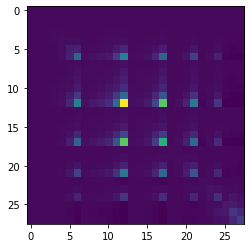

In [15]:
plt.imshow(cov)